To unzip the dataset and save





In [1]:
import os
import shutil
import zipfile


zip_file_path = "/content/Pothole_Segmentation_YOLOv8.v1i.yolov8.zip"

dataset_dir = "dataset"


os.makedirs(dataset_dir, exist_ok=True)

# Unzip the file
try:
    print(f"Unzipping {zip_file_path} to {dataset_dir}...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)
    print("Unzipping complete.")

    print("\nContents of the 'dataset' folder:")
    for item in os.listdir(dataset_dir):
        print(f"  - {item}")

except FileNotFoundError:
    print(f"Error: The file '{zip_file_path}' was not found. Please upload it to your Colab environment first.")
except zipfile.BadZipFile:
    print(f"Error: The file '{zip_file_path}' is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Unzipping /content/Pothole_Segmentation_YOLOv8.v1i.yolov8.zip to dataset...
Unzipping complete.

Contents of the 'dataset' folder:
  - train
  - README.dataset.txt
  - README.roboflow.txt
  - data.yaml
  - valid


Training of the model


In [2]:
!pip install ultralytics
!pip install roboflow
!pip install matplotlib seaborn

import os
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
import cv2
import numpy as np
from PIL import Image
import torch
import shutil
from pathlib import Path

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 84.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with

In [3]:
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

CUDA available: True
GPU: Tesla T4


Dataset Validation and checking.

In [4]:
dataset_path = "/content/dataset"
print(f"Dataset path: {dataset_path}")


if not os.path.exists(dataset_path):
    print("Dataset not found! Please upload your dataset to /content/dataset")
else:
    print("Dataset found!")


    print("\nDataset contents:")
    for item in os.listdir(dataset_path):
        item_path = os.path.join(dataset_path, item)
        if os.path.isdir(item_path):
            print(f"   {item}/")

            for subitem in os.listdir(item_path)[:5]:
                print(f"    - {subitem}")
            if len(os.listdir(item_path)) > 5:
                print(f"   ... and {len(os.listdir(item_path)) - 5} more files")
        else:
            print(f"   {item}")


yaml_path = os.path.join(dataset_path, "data.yaml")
if os.path.exists(yaml_path):
    print("\n data.yaml found!")
    with open(yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)
    print("Configuration:")
    print(yaml.dump(data_config, default_flow_style=False))
else:
    print("\n data.yaml not found!")

Dataset path: /content/dataset
Dataset found!

Dataset contents:
   train/
    - labels
    - images
   README.dataset.txt
   README.roboflow.txt
   data.yaml
   valid/
    - labels
    - images

 data.yaml found!
Configuration:
names:
- Pothole
nc: 1
roboflow:
  license: CC BY 4.0
  project: pothole_segmentation_yolov8
  url: https://universe.roboflow.com/farzad/pothole_segmentation_yolov8/dataset/1
  version: 1
  workspace: farzad
test: ../test/images
train: ../train/images
val: ../valid/images



Yaml modificaiton.


In [5]:
data_config = {
    'path': dataset_path,
    'train': 'train/images',
    'val': 'valid/images',
    'nc': 1,  # Number of classes (pothole)
    'names': ['pothole']
}

# Write updated data.yaml
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f, default_flow_style=False)

print("Updated data.yaml configuration:")
print(yaml.dump(data_config, default_flow_style=False))

# Verify train and validation directories
train_img_path = os.path.join(dataset_path, "train", "images")
train_label_path = os.path.join(dataset_path, "train", "labels")
val_img_path = os.path.join(dataset_path, "valid", "images")
val_label_path = os.path.join(dataset_path, "valid", "labels")

print(f"\nTrain images: {len(os.listdir(train_img_path)) if os.path.exists(train_img_path) else 'Not found'}")
print(f"Train labels: {len(os.listdir(train_label_path)) if os.path.exists(train_label_path) else 'Not found'}")
print(f"Val images: {len(os.listdir(val_img_path)) if os.path.exists(val_img_path) else 'Not found'}")
print(f"Val labels: {len(os.listdir(val_label_path)) if os.path.exists(val_label_path) else 'Not found'}")

Updated data.yaml configuration:
names:
- pothole
nc: 1
path: /content/dataset
train: train/images
val: valid/images


Train images: 720
Train labels: 720
Val images: 60
Val labels: 60


Trainining


In [6]:

print(" Starting YOLOv8 Training...")

# Initialize YOLOv8 model
model = YOLO('yolov8n.pt')

# Training parameters
training_params = {
    'data': yaml_path,
    'epochs': 100,
    'imgsz': 640,
    'batch': 16,
    'lr0': 0.01,
    'patience': 10,
    'save_period': 10,
    'project': '/content/runs',
    'name': 'pothole_detection',
    'exist_ok': True,
    'pretrained': True,
    'optimizer': 'SGD',
    'verbose': True,
    'seed': 42,
    'deterministic': True,
    'single_cls': False,
    'rect': False,
    'cos_lr': False,
    'close_mosaic': 10,
    'resume': False,
    'amp': True,
    'fraction': 1.0,
    'profile': False,
    'freeze': None,
}

print("Training parameters:")
for key, value in training_params.items():
    print(f"  {key}: {value}")

# Start training
print("\n🏋️ Training started...")
results = model.train(**training_params)

print("\n Training completed!")
print(f"Best weights saved at: {model.trainer.best}")
print(f"Last weights saved at: {model.trainer.last}")

 Starting YOLOv8 Training...
Training parameters:
  data: /content/dataset/data.yaml
  epochs: 100
  imgsz: 640
  batch: 16
  lr0: 0.01
  patience: 10
  save_period: 10
  project: /content/runs
  name: pothole_detection
  exist_ok: True
  pretrained: True
  optimizer: SGD
  verbose: True
  seed: 42
  deterministic: True
  single_cls: False
  rect: False
  cos_lr: False
  close_mosaic: 10
  resume: False
  amp: True
  fraction: 1.0
  profile: False
  freeze: None

🏋️ Training started...
Ultralytics 8.3.195 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=

Model evaluation along with graph plotted

 Evaluating trained model...
Ultralytics 8.3.195 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1670.2±319.6 MB/s, size: 81.3 KB)
val: Scanning /content/dataset/valid/labels.cache... 60 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 60/60 45.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 1.0it/s 3.9s
                   all         60        201      0.708      0.662      0.718      0.431
Speed: 13.3ms preprocess, 20.0ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to /content/runs/detect/val

 Validation Results:
mAP50: 0.7175
mAP50-95: 0.4314
Precision: 0.7075
Recall: 0.6617
Results plot not found
Confusion matrix not found
Validation batch predictions not found


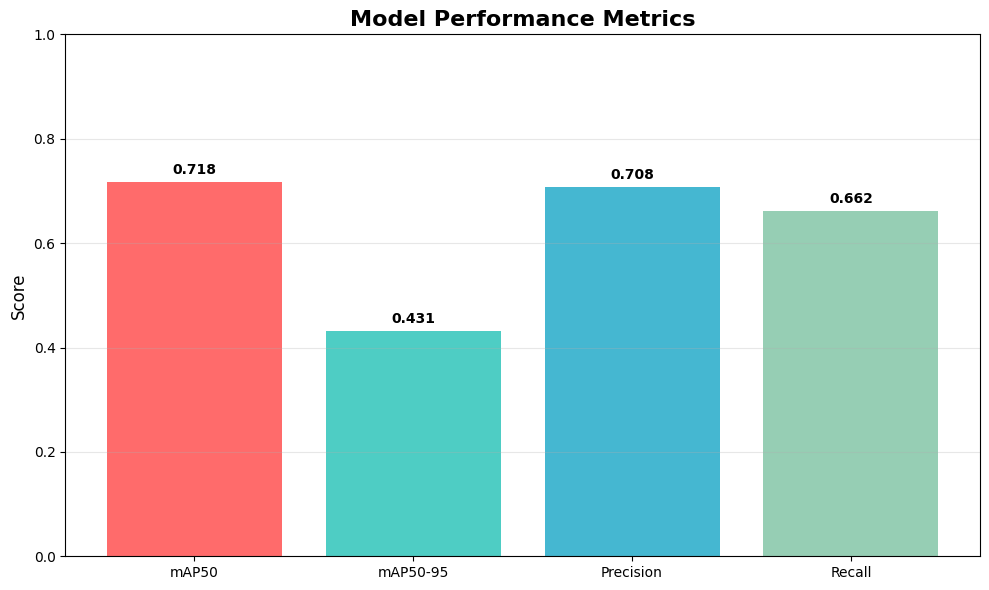

In [7]:
print(" Evaluating trained model...")


best_model_path = model.trainer.best
best_model = YOLO(best_model_path)

validation_results = best_model.val()

print("\n Validation Results:")
print(f"mAP50: {validation_results.box.map50:.4f}")
print(f"mAP50-95: {validation_results.box.map:.4f}")
print(f"Precision: {validation_results.box.mp:.4f}")
print(f"Recall: {validation_results.box.mr:.4f}")

def plot_training_results():
    results_dir = '/content/runs/pothole_detection'


    exp_dirs = [d for d in os.listdir(results_dir) if d.startswith('train')]
    if exp_dirs:
        latest_exp = max(exp_dirs, key=lambda x: os.path.getctime(os.path.join(results_dir, x)))
        results_path = os.path.join(results_dir, latest_exp)


        results_img_path = os.path.join(results_path, 'results.png')
        if os.path.exists(results_img_path):
            plt.figure(figsize=(15, 10))
            img = plt.imread(results_img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.title('Training Results')
            plt.tight_layout()
            plt.show()
        else:
            print("Results plot not found")


        confusion_matrix_path = os.path.join(results_path, 'confusion_matrix.png')
        if os.path.exists(confusion_matrix_path):
            plt.figure(figsize=(8, 6))
            img = plt.imread(confusion_matrix_path)
            plt.imshow(img)
            plt.axis('off')
            plt.title('Confusion Matrix')
            plt.tight_layout()
            plt.show()
        else:
            print("Confusion matrix not found")


        val_batch_path = os.path.join(results_path, 'val_batch0_pred.jpg')
        if os.path.exists(val_batch_path):
            plt.figure(figsize=(15, 10))
            img = plt.imread(val_batch_path)
            plt.imshow(img)
            plt.axis('off')
            plt.title('Validation Predictions Sample')
            plt.tight_layout()
            plt.show()
        else:
            print("Validation batch predictions not found")


plot_training_results()


def create_metrics_plot():
    metrics = {
        'Metric': ['mAP50', 'mAP50-95', 'Precision', 'Recall'],
        'Value': [
            validation_results.box.map50,
            validation_results.box.map,
            validation_results.box.mp,
            validation_results.box.mr
        ]
    }

    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics['Metric'], metrics['Value'], color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    plt.title('Model Performance Metrics', fontsize=16, fontweight='bold')
    plt.ylabel('Score', fontsize=12)
    plt.ylim(0, 1)


    for bar, value in zip(bars, metrics['Value']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

create_metrics_plot()

Testing the trained model

 Testing trained model...
Testing on 6 validation images...

image 1/1 /content/dataset/valid/images/pic-273-_jpg.rf.36d10c68fb23799bd0a58e48e0b995ce.jpg: 640x640 1 pothole, 8.9ms
Speed: 2.6ms preprocess, 8.9ms inference, 8.8ms postprocess per image at shape (1, 3, 640, 640)

pic-273-_jpg.rf.36d10c68fb23799bd0a58e48e0b995ce.jpg: 1 potholes detected
  Detection 1: Confidence = 0.820

image 1/1 /content/dataset/valid/images/pic-292-_jpg.rf.f3d0a40ac5190529f4dd4886d6f5e5d0.jpg: 640x640 2 potholes, 18.1ms
Speed: 2.4ms preprocess, 18.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

pic-292-_jpg.rf.f3d0a40ac5190529f4dd4886d6f5e5d0.jpg: 2 potholes detected
  Detection 1: Confidence = 0.704
  Detection 2: Confidence = 0.599

image 1/1 /content/dataset/valid/images/pic-125-_jpg.rf.3d316e9144cb7438021e01065de91057.jpg: 640x640 22 potholes, 18.2ms
Speed: 10.3ms preprocess, 18.2ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

pic-125-_jpg.rf.3d316e9144cb743

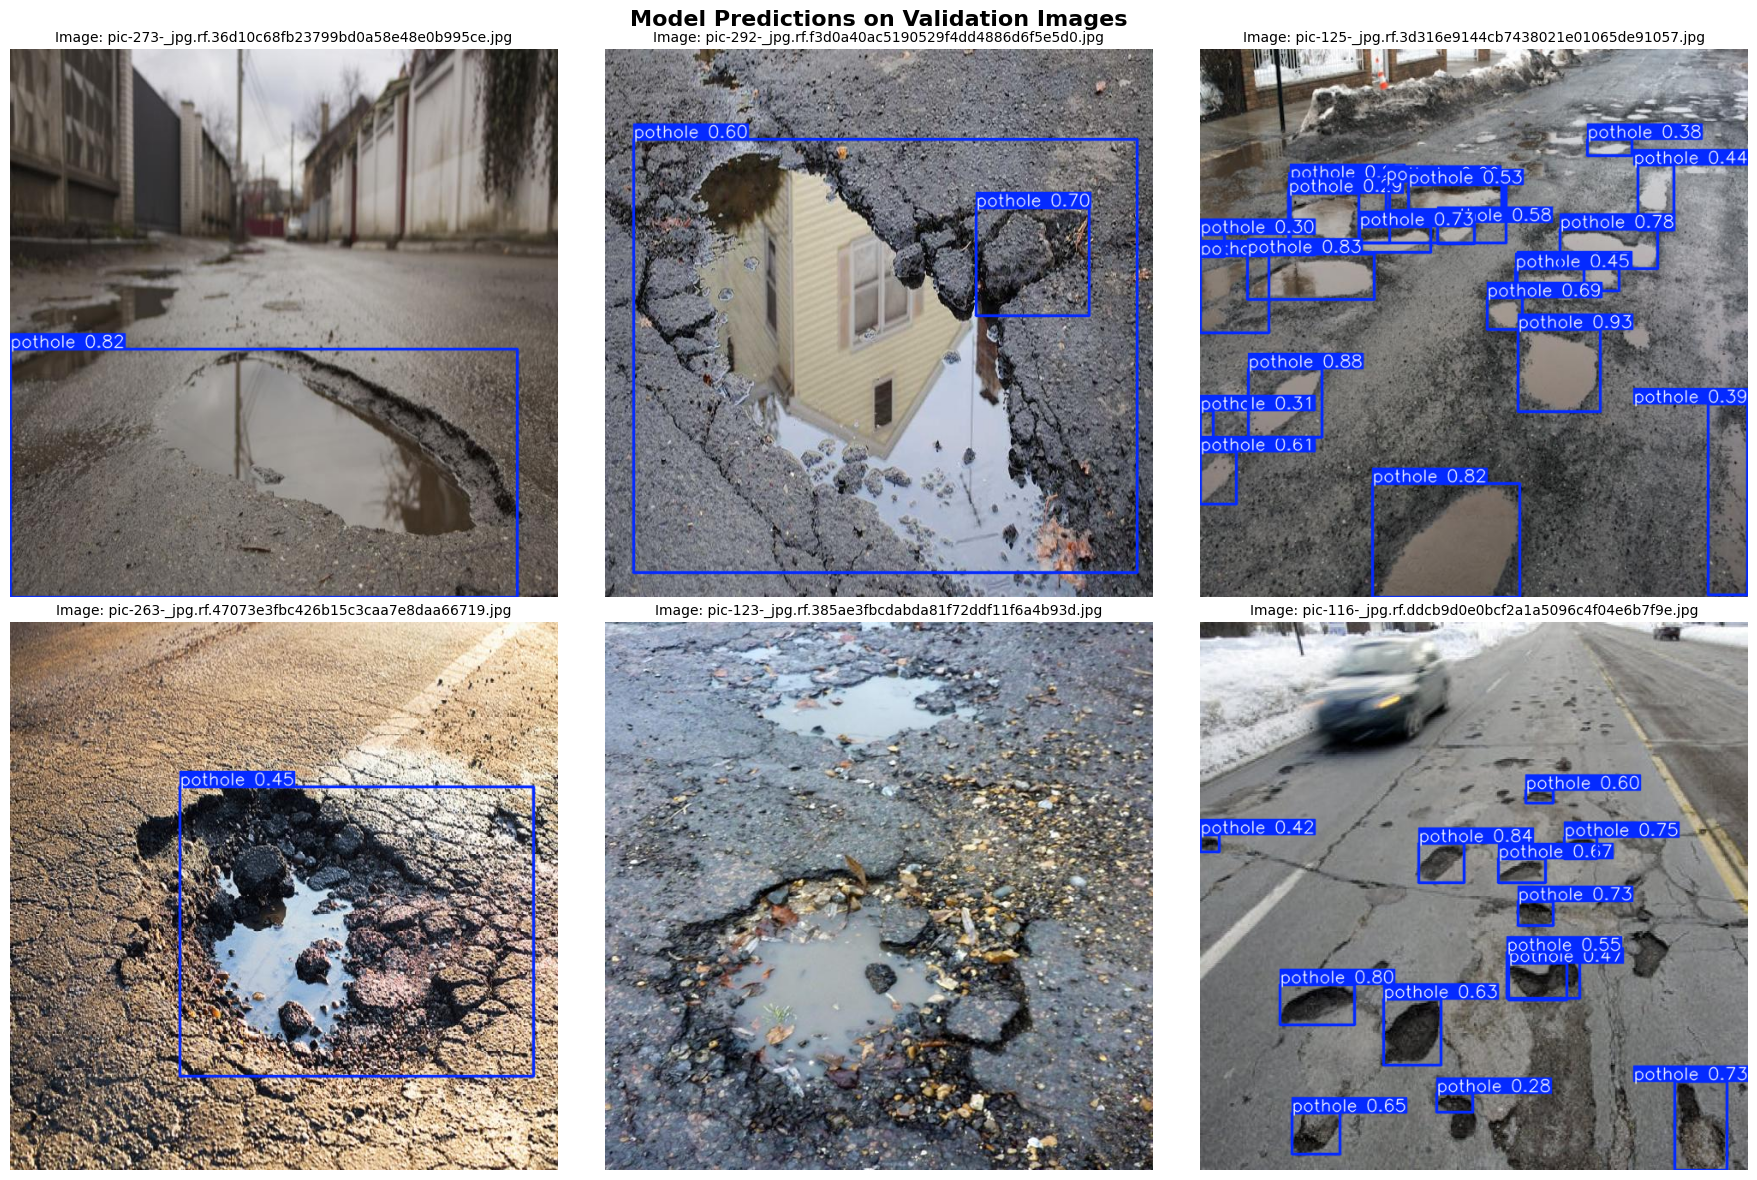


 Analyzing: /content/dataset/valid/images/pic-273-_jpg.rf.36d10c68fb23799bd0a58e48e0b995ce.jpg

image 1/1 /content/dataset/valid/images/pic-273-_jpg.rf.36d10c68fb23799bd0a58e48e0b995ce.jpg: 640x640 1 pothole, 11.4ms
Speed: 2.5ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


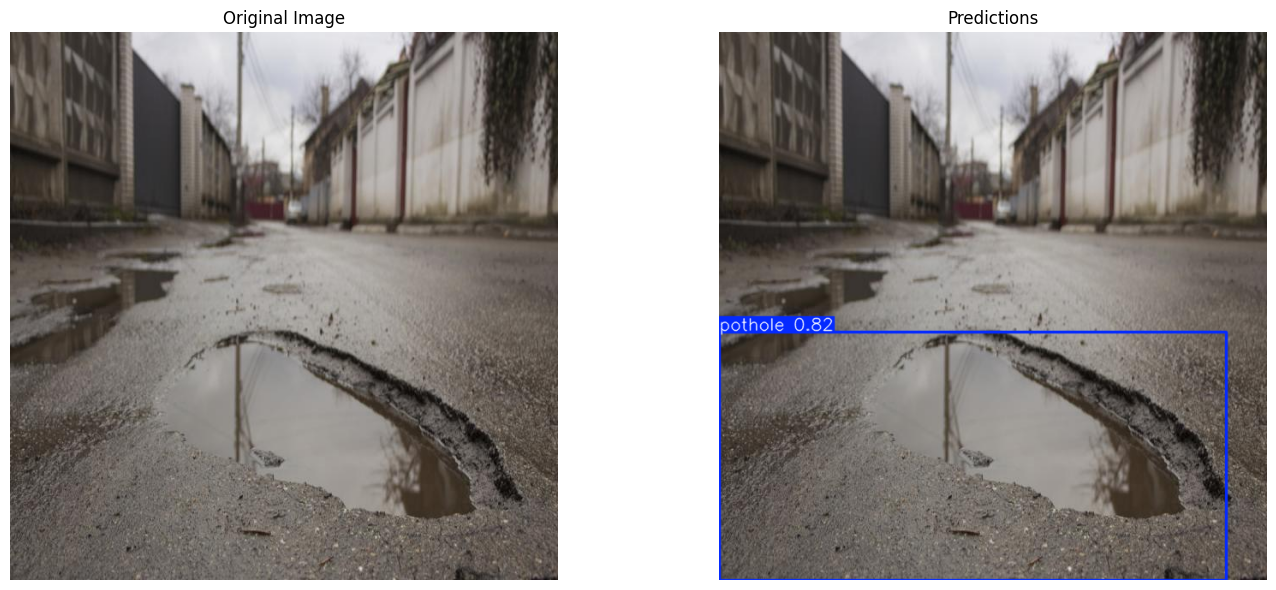

Found 1 potholes:
  Pothole 1:
    Confidence: 0.820
    Bounding box: [0, 350, 592, 640]
    Size: 592 x 289 pixels

 Model testing completed!


In [8]:
print(" Testing trained model...")


model_path = best_model_path
trained_model = YOLO(model_path)

def test_model_on_validation_images():
    """Test model on some validation images"""
    val_images_path = os.path.join(dataset_path, "valid", "images")

    if not os.path.exists(val_images_path):
        print("Validation images directory not found!")
        return


    image_files = [f for f in os.listdir(val_images_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:6]

    if not image_files:
        print("No image files found in validation directory!")
        return

    print(f"Testing on {len(image_files)} validation images...")


    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    for i, img_file in enumerate(image_files):
        img_path = os.path.join(val_images_path, img_file)


        results = trained_model(img_path)


        result_img = results[0].plot()


        result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

        axes[i].imshow(result_img_rgb)
        axes[i].set_title(f'Image: {img_file}', fontsize=10)
        axes[i].axis('off')


        detections = results[0].boxes
        if detections is not None:
            print(f"\n{img_file}: {len(detections)} potholes detected")
            for j, box in enumerate(detections):
                conf = box.conf[0].item()
                print(f"  Detection {j+1}: Confidence = {conf:.3f}")
        else:
            print(f"\n{img_file}: No potholes detected")

    plt.suptitle('Model Predictions on Validation Images', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


test_model_on_validation_images()

def predict_single_image(image_path, confidence_threshold=0.5):
    """Predict on a single image with detailed output"""

    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return

    print(f"\n Analyzing: {image_path}")


    results = trained_model(image_path, conf=confidence_threshold)


    result = results[0]


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


    original_img = cv2.imread(image_path)
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    ax1.imshow(original_img_rgb)
    ax1.set_title('Original Image')
    ax1.axis('off')


    predicted_img = result.plot()
    predicted_img_rgb = cv2.cvtColor(predicted_img, cv2.COLOR_BGR2RGB)
    ax2.imshow(predicted_img_rgb)
    ax2.set_title('Predictions')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    if result.boxes is not None:
        boxes = result.boxes
        print(f"Found {len(boxes)} potholes:")
        for i, box in enumerate(boxes):
            conf = box.conf[0].item()
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            print(f"  Pothole {i+1}:")
            print(f"    Confidence: {conf:.3f}")
            print(f"    Bounding box: [{int(x1)}, {int(y1)}, {int(x2)}, {int(y2)}]")
            print(f"    Size: {int(x2-x1)} x {int(y2-y1)} pixels")
    else:
        print("No potholes detected")

    return results


val_images_path = os.path.join(dataset_path, "valid", "images")
if os.path.exists(val_images_path):
    sample_images = [f for f in os.listdir(val_images_path)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if sample_images:
        sample_image_path = os.path.join(val_images_path, sample_images[0])
        predict_single_image(sample_image_path, confidence_threshold=0.3)

print("\n Model testing completed!")

Model exporting and rechecking.

In [9]:

print(" Saving and exporting model...")


export_dir = "/content/exported_models"
os.makedirs(export_dir, exist_ok=True)


best_weights_copy = os.path.join(export_dir, "best_pothole_model.pt")
shutil.copy2(best_model_path, best_weights_copy)
print(f" Best model saved to: {best_weights_copy}")


try:

    onnx_path = trained_model.export(format="onnx", dynamic=True)
    print(f" ONNX model exported to: {onnx_path}")
except Exception as e:
    print(f" ONNX export failed: {e}")

try:
    # Export to TensorRT format (if available)
    # engine_path = trained_model.export(format="engine")
    # print(f" TensorRT model exported to: {engine_path}")
    print(" Skipping TensorRT export (requires specific setup)")
except Exception as e:
    print(f" TensorRT export failed: {e}")


model_info = {
    'model_type': 'YOLOv8n',
    'dataset': 'Pothole Detection',
    'classes': ['pothole'],
    'input_size': 640,
    'map50': float(validation_results.box.map50),
    'map50_95': float(validation_results.box.map),
    'precision': float(validation_results.box.mp),
    'recall': float(validation_results.box.mr),
    'epochs_trained': training_params['epochs'],
    'best_weights_path': best_weights_copy
}


model_info_path = os.path.join(export_dir, "model_info.yaml")
with open(model_info_path, 'w') as f:
    yaml.dump(model_info, f, default_flow_style=False)

print(f" Model information saved to: {model_info_path}")


 Saving and exporting model...
 Best model saved to: /content/exported_models/best_pothole_model.pt
Ultralytics 8.3.195 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/content/runs/pothole_detection/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim>=0.1.67', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 8.7s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.19.0 opset 19...
ONNX: slimming with onnxslim 0.1.67...
ONNX: export success ✅ 11.7s, saved as '/content/runs/pothole_detection/weights/best.onnx' (11.6 MB)

Export complete (12.3s)
Results saved to /content/runs/pothole_det